**Referencias:**
* [UNet model Original creator Reference link](https://github.com/zhixuhao/unet)
* [Kaggle Notebook - SAMUEL CORTINHAS](https://www.kaggle.com/code/samuelcortinhas/case-study-u-net-from-scratch#Application:-Tumor-detection)
* [UNet from Scratch - segmentation 🧠 Tumour](https://www.kaggle.com/code/tejasurya/unet-from-scratch-segmentation-tumour) - Main Source in Keras
* [Pytorch Lightning - UNet from Scratch - segmentation 🧠 Tumour](https://www.kaggle.com/code/heiswicked/pytorch-lightning-unet-segmentation-tumour) - Main Source in Pytorch

# <p style="background-color:red;color:white;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid black">Brain MRI Detector | Segmentation | Using UNet</p>

<center><img src= "https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg" alt ="Brain-MRI" style='width:300px;'></center>

**Image source** : Mayo Clinic

# Quick Index

* [Introduction](#1)
* [What is Image Segmentation?](#1.1)
* [EDA](#2)
* [Image Visualization](#2.1)
* [Data Generator](#3)
* [Build UNet](#4)
    * [UNet Architecture](#4.1)
* [UNet Implementation](#5)    
    * [Callbacks](#5.1)
    * [Performance Metrics](#5.2)
    * [Model Fit](#5.3)
    * [Save UNet Model](#5.4)
* [Evaluation](#6)
* [Prediction](#7)

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Introducción</span> <a id=1></a>
Un tumor cerebral es una masa o crecimiento de células anormales en el cerebro. Existen muchos tipos diferentes de tumores cerebrales. Algunos tumores cerebrales no son cancerosos (benignos) y otros son cancerosos (malignos). Los tumores cerebrales pueden comenzar en el cerebro (tumores cerebrales primarios), o en otras partes del cuerpo y extenderse al cerebro como tumores cerebrales secundarios (metastásicos).

La rapidez con que crece un tumor cerebral puede variar mucho. La tasa de crecimiento y la ubicación de un tumor cerebral determinan cómo afectará la función de su sistema nervioso.

Las opciones de tratamiento del tumor cerebral dependen del tipo de tumor cerebral que tenga, así como de su tamaño y ubicación. <br>
**Fuente** : [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)

# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Segmentación de imágenes</span> <a id=1.1></a> <br>

El objetivo de la segmentación de imágenes es clasificar cada píxel de una imagen con la clase que representa. En este ejercicio, vamos a aplicar un modelo de segmentación muy conocido en imagen médica, el modelo U-Net, para detectar tumores en imágenes de resonancia magnética.


# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px"> Instalación de librerías y modelos Pytorch</span> <a id=1.1.1></a> <br>

In [ ]:
# !pip install -qqq wandb
!pip install -qqq torchmetrics
!pip install -qqq pytorch-lightning
!pip install -qqq segmentation-models-pytorch

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

import wandb
from pytorch_lightning.loggers import WandbLogger

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp

from pprint import pprint

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

In [ ]:
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
# Cargamos el dataset con información de las imágenes MRI
img_data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
# Por el tamaño podemos ver que hay 110 imágenes
img_data.shape

(110, 18)

In [ ]:
# Creamos una lista con la ruta de las imágenes
data_path = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
# Seleccionamos los archivos correctos
filenames = data_path[::2]
masks = data_path[1::2]

In [ ]:
# Creamos dataframe con la información de cada paciente y sus imágenes
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print(df.shape)
df

(7858, 2)


,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
7853,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [ ]:
# Separamos las imágenes según son imágenes de MRI o máscaras
original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [ ]:
original_img, mask_img

(                 patient_id                                           img_path
 0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 5     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ...                     ...                                                ...
 7849  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7850  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [3929 rows x 2 columns],
            

In [ ]:
# Ordenamos alfabéticamente los nombres de las imágenes y máscaras para que estén alineados
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

# Comprobamos que se ha ordenado correctamente
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_36.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_36_mask.tif


In [ ]:
# Creamos un nuevo df con toda la información
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})

# Mostramos las primeras filas
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [ ]:
# La máscara se usa para identificar el tumor
# por lo tanto, si hay algo en la imágenes de la máscara significa
# que hay tumor en la imágen MRI del paciente

# Para obtener esta información, creamos una pequeña función que devuelve 1 si
# hay algun valor mayor a 0 en la imagen de la máscara
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 :
        return 1
    else:
        return 0

In [ ]:
# Aplicamos la función a las imágenes de las mascaras
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

# Aseguramos que la ruta de la máscara es un string
mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))

# Mostramos el tamaño y las primeras filas del df
print(mri_df.shape)
mri_df.head()

(3929, 4)


,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [ ]:
# Ya no necesitamos el ID del paciente, por lo tanto, lo podemos eliminar
mri_df.drop(columns=['patient_id'],inplace=True)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Exploración de datos</span> <a id=2></a> <br>

<AxesSubplot:title={'center':'Count of Tumour vs No Tumour'}>

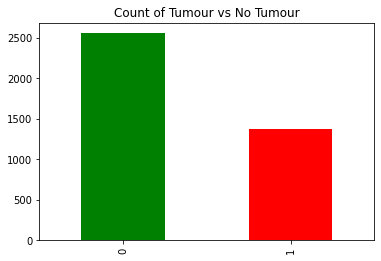

In [ ]:
# Miramos como se distribuyen los grupos (Pacientes con y sin tumor)

# Mostramos un gráfico de barras
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [ ]:
# También podemos representar esta información
# contando el número de pacientes por grupo
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Visualización de las imágenes</span> <a id=2.1></a> <br>

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


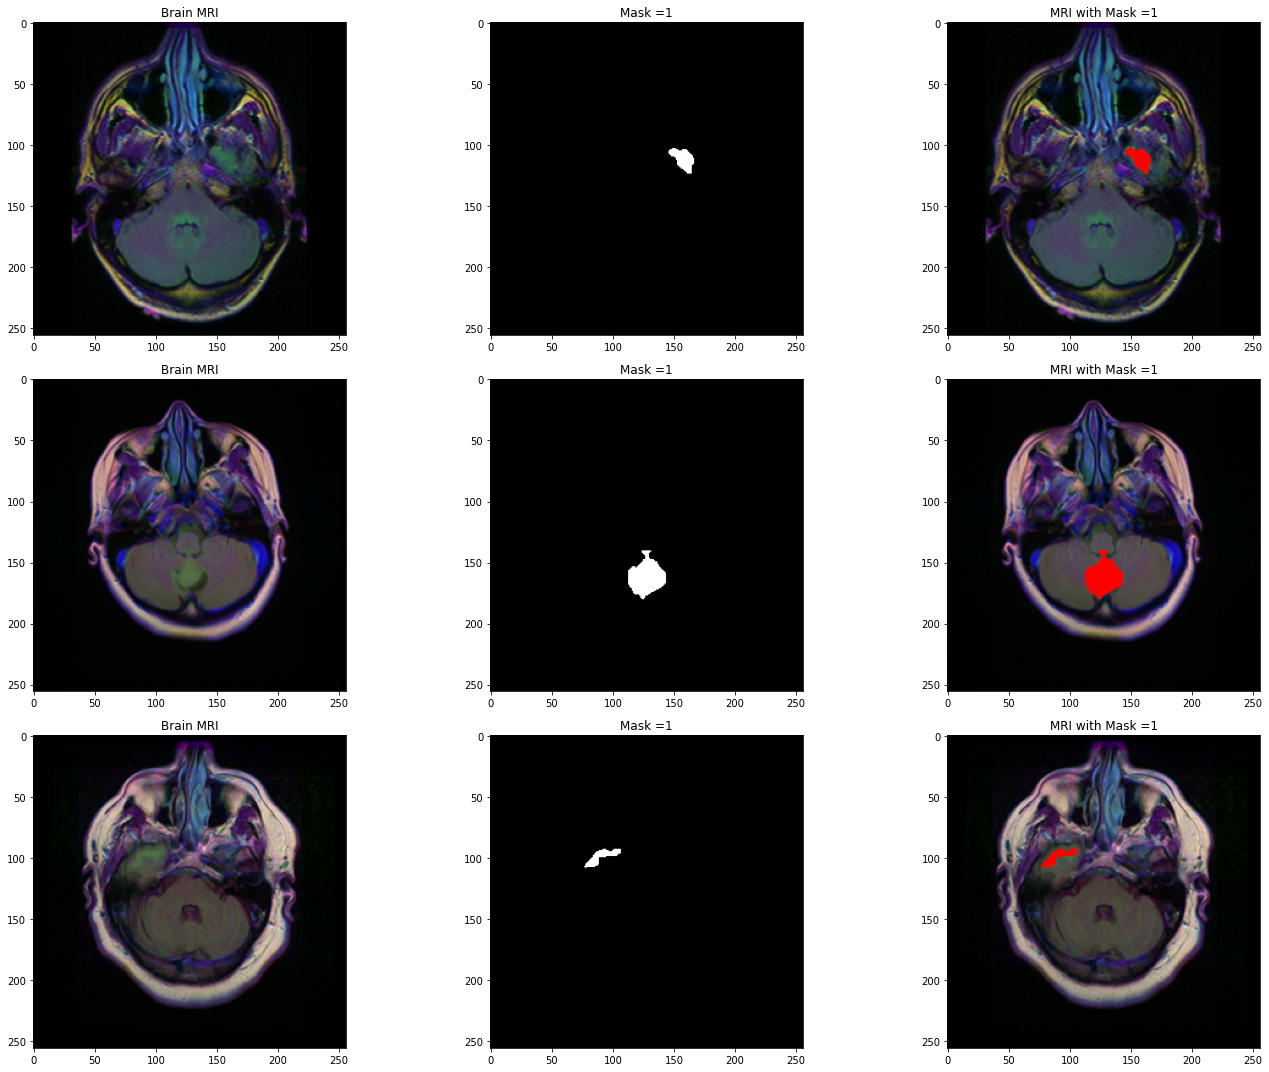

In [ ]:
# A continuación, vamos a visualizar las imágenes de MRI de 3 pacientes sus máscaras
# También vamos a mostrar las 2 imágenes juntas,
# para identificar mejor  dónde está el tumor

count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    # solo mostramos las imágenes si se ha encontrado tumor (mask=1)
    if (mask==1):
        # Mostramos la imagen de MR estructural
        img = io.imread(mri_df.img_path[i])
        print(img.shape)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        # Mostramos la imagen de la máscara
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')

        # Mostramos la imagen MR junto con la máscara
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        # Incrementamos el contador, para que el for para cuando llegue a 3
        count +=1
    i += 1
    if (count==3):
        break

fig.tight_layout()

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Preparando estructuras de Pytorch (dataloaders, dataset)</span> <a id=3></a> <br>

In [ ]:
# torchvision.transforms.Compose permite juntar distintas transformaciones
# aunque en este caso solo hay una, la transformación de las imágenes a tensores

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  ])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

Un poco más de información sobre las funciones:

- torchvision.transforms.Compose: Esta función permite aplicar una serie de transformaciones en secuencia a una imagen.
- torchvision.transforms.ToTensor(): Esta transformación convierte una imagen PIL (Python Imaging Library) o un array NumPy en un tensor de tipo torch.Tensor.

Los tensores en PyTorch son estructuras de datos fundamentales que se utilizan en la computación de tensores. Convertir una imagen a un tensor es una etapa común en el preprocesamiento de datos para su uso en modelos de redes neuronales.

## <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Dataset</span> <a id=1.1.1></a> <br>

La función `adjust_data` lleva a cabo la normalización de las imágenes y las máscaras utilizadas en el procesamiento de datos para tareas de segmentación.

In [ ]:
# Normalización de las imágenes
def adjust_data(img, mask):
    # Normalizamos valores de los píxels (normalmente van de 0 a 255)
    img = img / 255.
    mask = mask / 255.
    # Definimos un umbral para la máscara
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0

    return (img, mask)


Esta función define una clase llamada MyDataset que hereda de la clase Dataset de PyTorch. Esta clase se utiliza para crear un conjunto de datos personalizado para el entrenamiento de modelos de redes neuronales convolucionales (CNN).

Cada método de la clase MyDataset hace lo siguiente:

- __init__(self, df= mri_df, adjust_data=adjust_data, image_transform=image_transform, mask_transform=mask_transform): Este método inicializa el conjunto de datos. Toma cuatro argumentos opcionales: df, adjust_data, image_transform y mask_transform. df es un DataFrame que contiene las rutas de las imágenes MRI y sus máscaras correspondientes. adjust_data es una función para ajustar los datos de imagen y máscara. image_transform y mask_transform son transformaciones que se aplicarán a la imagen y la máscara respectivamente. Estos argumentos se asignan como atributos de la clase.

- __len__(self): Este método devuelve la longitud del conjunto de datos, que es el número de muestras en el DataFrame df.

- __getitem__(self, idx): Este método permite acceder a los elementos del conjunto de datos mediante el índice idx. Primero, obtiene las rutas de la imagen y la máscara correspondiente para el índice dado. Luego, carga la imagen y la máscara utilizando OpenCV (cv2), convierte la imagen a RGB y la máscara a escala de grises. Después, aplica la función adjust_data para ajustar la imagen y la máscara. Luego, si se han proporcionado transformaciones (image_transform o mask_transform), las aplica a la imagen y la máscara respectivamente. Finalmente, devuelve la imagen y la máscara.

In [ ]:
# Se crea la clase MyDataset
class MyDataset(Dataset):
    # Inicializamos los atributos de la clase
    def __init__(self, df= mri_df,
                 adjust_data = adjust_data,
                 image_transform=image_transform, mask_transform=mask_transform):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data= adjust_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # dado un índice, guardamos la ruta de la imagen y la máscara
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        # Leemos las imágenes con cv2
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        # La imagen estructural la transformamos a RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # La imagen de la máscara la transformamos a escala de grises
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Aplica la función adjust_data definida anteriormente
        image, mask = self.adjust_data(image, mask)

        # Si hay transformaciones definidas, las aplica para las 2 imágenes
        # En este caso, se transforman las imágenes a tensores para utilizarse en Pytorch
        if self.image_transform:
            image = self.image_transform(image).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

In [ ]:
# Comprobamos que la clase MyDataset() funciona correctamente

# Especificamos un índice
index = 2911

# Cargamos los datos para ese índice
data = MyDataset()[index]

# Mostramos el tamaño de la imagen y la máscara en forma de tensor
data[0].shape, data[1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

En PyTorch, las imágenes están representadas como tensores en el formato (C x H x W), donde C representa los canales de color (por ejemplo, 3 para imágenes RGB), H representa la altura de la imagen y W representa el ancho de la imagen. Esta operación `permute` reorganiza las dimensiones del tensor de manera que el primer índice sea el canal de color, el segundo índice sea la altura y el tercer índice sea el ancho. Esto es necesario porque imshow de matplotlib espera que las imágenes estén en el formato (H x W x C), donde C representa los canales de color.

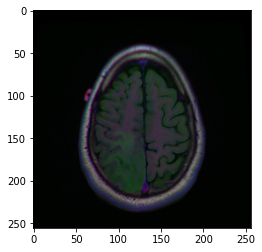

In [ ]:
# Visualizamos la imágen estructural
plt.imshow(data[0].permute(1, 2, 0).numpy())

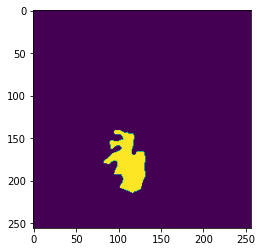

In [ ]:
# Visualizamos la imágen de la máscara
plt.imshow(data[1].permute(1, 2, 0).squeeze(-1).numpy())

# squeeze(-1) elimina la última dimensión del tensor,
# ya que es una imágen en escala de grises

## <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">DataLoader</span> <a id=1.1.1></a> <br>

La función llamada `prepare_loaders` se usa para preparar los conjuntos de datos y los cargadores de datos (DataLoaders) necesarios para el entrenamiento, validación y prueba de un modelo. Aquí está lo que hace la función:

- `df= mri_df, train_num= int(mri_df.shape[0] * .6), valid_num= int(mri_df.shape[0] * .8), bs = 32`: Esta función toma cuatro argumentos opcionales. `df` es un DataFrame que contiene las rutas de las imágenes MRI y sus máscaras correspondientes. `train_num` y `valid_num` son los índices que definen los límites entre los conjuntos de datos de entrenamiento, validación y prueba. `bs` es el tamaño del lote (batch size) que se utilizará en los cargadores de datos.

- `train = df[:train_num].reset_index(drop=True)`, `valid = df[train_num : valid_num].reset_index(drop=True)`, `test  = df[valid_num:].reset_index(drop=True)`: Estas líneas dividen el DataFrame `df` en tres conjuntos de datos distintos: entrenamiento, validación y prueba, utilizando los índices proporcionados. Se utiliza el método `reset_index(drop=True)` para reindexar los nuevos DataFrames resultantes para que los índices vayan de 0 a N-1.

- `train_ds = MyDataset(df = train)`, `valid_ds = MyDataset(df = valid)`, `test_ds = MyDataset(df = test)`: Se crean instancias de la clase `MyDataset` para cada conjunto de datos (entrenamiento, validación y prueba), pasando los DataFrames correspondientes como argumentos.

- `train_loader = DataLoader(train_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = True)`, `valid_loader = DataLoader(valid_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = False)`, `test_loader = DataLoader(test_ds, batch_size = 4, num_workers = os.cpu_count(), shuffle = True)`: Se crean los cargadores de datos utilizando la clase `DataLoader` de PyTorch. Se especifica el tamaño del lote (`batch_size`), el número de trabajadores de procesamiento de datos (`num_workers`) y si se desea mezclar los datos en cada época (`shuffle`). Para el conjunto de prueba, el tamaño del lote se establece en 4.

- `print("DataLoader Completed")`: Imprime un mensaje para indicar que se han creado los cargadores de datos.

- `return train_loader, valid_loader, test_loader`: La función devuelve los cargadores de datos para los conjuntos de entrenamiento, validación y prueba.

En resumen, esta función `prepare_loaders` automatiza la preparación de los conjuntos de datos y los cargadores de datos necesarios para el entrenamiento, validación y prueba de un modelo utilizando DataFrames de Pandas y las clases `MyDataset` y `DataLoader` de PyTorch.

In [ ]:
def prepare_loaders(df= mri_df, # valores por defecto
                    train_num= int(mri_df.shape[0] * .6),
                    valid_num= int(mri_df.shape[0] * .8),
                    bs = 32):

    # Se separa el df en 3 conjuntos (entrenamiento, validación y test)
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)
    test  = df[valid_num:].reset_index(drop=True)

    #Se crean instancias de la clase MyDataset para cada conjunto de datos
    #(entrenamiento, validación y test),
    # pasando los DataFrames correspondientes como argumentos
    train_ds = MyDataset(df = train)
    valid_ds = MyDataset(df = valid)
    test_ds = MyDataset(df = test)

    # Se crean los cargadores de datos utilizando la clase DataLoader de PyTorch.
    # Se especifica el tamaño del batch (batch_size),
    # el número de workers de procesamiento de datos (num_workers)
    # y si se desea mezclar los datos en cada epoch (shuffle).

    # batch size: número de ejemplos de entrenamiento utilizados en una iteración del algoritmo de entrenamiento.
    # Cuando entrenas un modelo de aprendizaje automático, no procesas todos los datos de entrenamiento a la vez,
    # ya que esto puede ser computacionalmente costoso y no es eficiente.
    # Lo que se hace es dividir los datos de entrenamiento en grupos más pequeños y procesar cada grupo por separado.

    # epoch: época es una unidad de medida utilizada para cuantificar el progreso
    # del entrenamiento de un modelo durante el proceso de aprendizaje automático,
    # representando una sola pasada completa a través de todo el conjunto de datos de entrenamiento.
    # Si se configura el número de épocas en 10, el modelo verá todas las muestras
    # de entrenamiento 10 veces en total durante el proceso de entrenamiento.

    train_loader = DataLoader(train_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, num_workers = os.cpu_count(), shuffle = True)

    print("DataLoader Completed")
    # La función devuelve los cargadores de datos para los conjuntos de entrenamiento, validación y test
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = prepare_loaders(df= mri_df,
                                                            train_num= int(mri_df.shape[0] * .65),
                                                            valid_num= int(mri_df.shape[0] * .85),
                                                            bs = 32)

DataLoader Completed


In [ ]:
# el iterador iter() crea un iterador sobre train_loader,
# y luego utiliza la función next() para obtener el siguiente elemento en ese iterador.
data = next(iter(train_loader))

# data[0] es la imagen estructural del primer elemento de train_loader
# data[1] es la imagen de la máscara del primer elemento de train_loader
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

# <p style="color:#FF0000;background-color:white;font-size:25px">Construcción del modelo UNet</span> <a id=4></a> <br>

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Arquitectura del modelo UNet</span> <a id=4.1></a>

<center><img src= "https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt ="UNet" style='width:800px;'></center>

UNet es una arquitectura de red neuronal convolucional (CNN) diseñada para la segmentación precisa de imágenes, especialmente en aplicaciones médicas. Su nombre proviene de la forma de su arquitectura, que se asemeja a una "U".

Esta arquitectura es popular en aplicaciones de segmentación de imágenes debido a su capacidad para capturar características a diferentes escalas y su capacidad para generar segmentaciones precisas incluso con conjuntos de datos de tamaño pequeño.

- **Parte del Codificador (Camino Contractivo)**: Comienza con capas de convolución 2D seguidas de activación ReLU y capas de Maxpooling2D para reducir progresivamente la resolución espacial de la entrada, extrayendo características importantes a diferentes escalas.

- **Upsampling2D**: Después del codificador, se utilizan capas de Upsampling2D para aumentar la resolución espacial de la salida y crear un camino de expansión.

- **Parte del Decodificador (Camino Expansivo)**: Utiliza capas de convolución 2D seguidas de activación ReLU y capas de Upsampling2D para expandir la resolución espacial de la salida del camino contractivo.

- **Conexión de Salto (Conexión Residual)**: Se agregan conexiones de salto que conectan capas del codificador con capas correspondientes del decodificador para ayudar en la transferencia de información a diferentes niveles de resolución.

- **Salida de Segmentación**: La salida final es un mapa de segmentación que clasifica cada píxel de la imagen de entrada como parte del objeto de interés o no.


In [ ]:
# Si hay GPU disponible se usa GPU, sino CPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

Este código define una clase `Block` que representa un bloque básico utilizado en un modelo de red neuronal convolucional (CNN) para procesar imágenes.

- `__init__(self, inputs=3, middles=64, outs=64)`: Este método inicializa la clase `Block`. Toma tres argumentos opcionales: `inputs`, `middles` y `outs`, que representan el número de canales de entrada, el número de canales intermedios y el número de canales de salida, respectivamente. Por defecto, se asume que hay 3 canales de entrada, 64 canales intermedios y 64 canales de salida. En el contexto de una imagen RGB típica, los canales de entrada serían 3 correspondientes a los canales de color (rojo, verde, azul).

- `super().__init__()`: Esta línea llama al método `__init__()` de la clase base `nn.Module`, lo que garantiza que se inicialicen correctamente los atributos de la clase base.

- `self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)`: Se define una capa de convolución (`conv1`) con `inputs` canales de entrada, `middles` canales de salida, un tamaño de kernel de 3x3, un stride de 1 y un padding de 1. Esto significa que la convolución producirá una salida con el mismo tamaño que la entrada.

- `self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)`: Se define otra capa de convolución (`conv2`) con `middles` canales de entrada y `outs` canales de salida, utilizando el mismo tamaño de kernel, stride y padding que `conv1`.

- `self.relu = nn.ReLU()`: Se define una función de activación ReLU (`relu`), que se aplicará después de cada capa de convolución para introducir no linealidad en la red.

- `self.bn = nn.BatchNorm2d(outs)`: Se define una capa de normalización por lotes (`bn`) que se aplicará después de la segunda capa de convolución (`conv2`). La normalización por lotes ayuda a estabilizar y acelerar el entrenamiento de la red.

- `self.pool = nn.MaxPool2d(2, 2)`: Se define una capa de max pooling (`pool`) con un tamaño de kernel de 2x2 y un stride de 2, que reducirá a la mitad el tamaño espacial de la entrada en cada dimensión.

- `forward(self, x)`: Este método define la operación de propagación hacia adelante de la red. Toma un tensor de entrada `x` y aplica las capas definidas en el método `__init__` en secuencia. Primero se aplica `conv1` seguido de una activación ReLU, luego se aplica `conv2` seguido de una activación ReLU y normalización por lotes (`bn`). Finalmente, se aplica una capa de max pooling (`pool`) y se devuelve la salida del max pooling junto con la salida intermedia después de `conv2`.

En resumen, la clase `Block` representa un bloque básico utilizado en una red neuronal convolucional para extraer características de una imagen y reducir su resolución espacial. Este bloque consta de dos capas de convolución seguidas de una activación ReLU, una capa de normalización por lotes y una capa de max pooling.

In [ ]:
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()
        # Inicializamos la clase con el número de canales de entrada (inputs),
        # el número de canales intermedios (middles)
        # y el número de canales de salida (outs)

        # Definimos una capa de convolución (conv1)
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        # Definimos otra capa de convolución (conv2)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        # Definimos la función de activación ReLU
        # Introduce no linealidad en la red
        self.relu = nn.ReLU()
        # Definimos una capa de normalización por batch
        # Ayuda a estabilizar y acelerar el entrenamiento de la red
        self.bn = nn.BatchNorm2d(outs)
        # Definimos una capa de maxpooling
        # Reduce a la mitad el tamaño espacial de la entrada en cada dimensión
        self.pool = nn.MaxPool2d(2, 2)

    # Este método define la operación de propagación hacia adelante (forward propagation)
    def forward(self, x):
      # Aplicamos conv1 seguido de una activación ReLU,
      # luego aplicamos conv2 seguido de una activación ReLU y normalización por batch (bn).
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))
        # Aplicamos una capa de max pooling (pool)
        # y se devuelve la salida del max pooling junto con la salida intermedia después de conv2
        return self.pool(x), x


In [ ]:
import torch.nn as nn

# A continuación se define la arquitectura UNet descrita anteriormente
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        # Definimos 5 bloques encoders
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)

        # Definimos capas de upsampling para aumentar el tamaño de la imagen durante la decodificación.
        # Definimos cuatro bloques de decodificación (de4, de3, de2, de1)

        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)

        # Definimos una capa de convolución final (conv_last) que produce la salida final de la red
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)

    # Definimos la función forward, que especifica cómo se propagan los datos a través de la red.
    # Mostramos también el tamaño de los input/output de cada paso
    def forward(self, x):
        # x: [bs, 3, 256, 256]

        x, e1 = self.en1(x)
        # x: [bs, 64, 128, 128]
        # e1: [bs, 64, 256, 256]

        x, e2 = self.en2(x)
        # x: [bs, 128, 64, 64]
        # e2: [bs, 128, 128, 128]

        x, e3 = self.en3(x)
        # x: [bs, 256, 32, 32]
        # e3: [bs, 256, 64, 64]

        x, e4 = self.en4(x)
        # x: [bs, 512, 16, 16]
        # e4: [bs, 512, 32, 32]

        _, x = self.en5(x)
        # x: [bs, 512, 16, 16]


        x = self.upsample4(x)
        # x: [bs, 512, 32, 32]
        x = torch.cat([x, e4], dim=1)
        # x: [bs, 1024, 32, 32]
        _,  x = self.de4(x)
        # x: [bs, 256, 32, 32]

        x = self.upsample3(x)
        # x: [bs, 256, 64, 64]
        x = torch.cat([x, e3], dim=1)
        # x: [bs, 512, 64, 64]
        _, x = self.de3(x)
        # x: [bs, 128, 64, 64]

        x = self.upsample2(x)
        # x: [bs, 128, 128, 128]
        x = torch.cat([x, e2], dim=1)
        # x: [bs, 256, 128, 128]
        _, x = self.de2(x)
        # x: [bs, 64, 128, 128]

        x = self.upsample1(x)
        # x: [bs, 64, 256, 256]
        x = torch.cat([x, e1], dim=1)
        # x: [bs, 128, 256,256, 256
        _, x = self.de1(x)
        # x: [bs, 64, 256, 256]

        x = self.conv_last(x)
        # x: [bs, 1, 256, 256]

        return x


In [ ]:
class UNETModel(pl.LightningModule):

    def __init__(self,):
        super().__init__()
        # Especificamos el modelo a usar (UNet)
        self.model = UNet()

        # Especificamos la función de pérdida (loss function)
        # El objetivo durante el entrenamiento del modelo es minimizar la función de pérdida,
        # ajustando los parámetros del modelo de manera que las predicciones se acerquen
        # lo más posible a los valores reales de los datos de entrenamiento.
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    # El método forward define cómo se propagan los datos a través del modelo.
    # Toma una imagen como entrada y devuelve la máscara predicha por el modelo.
    def forward(self, image):
        mask = self.model(image)
        return mask
    #  Este método se encarga de realizar una iteración de entrenamiento o validación con un lote de datos dado.
    # Se asegura de que las dimensiones de la imagen y la máscara sean correctas,
    # calcula la pérdida utilizando la función de pérdida definida anteriormente y
    # calcula métricas como precisión, recall, F1 y IoU.
    def shared_step(self, batch, stage):

        image = batch[0]

        # La forma de la imagen debe ser (tamaño_batch, núm_canales, alto, ancho)
        # si trabaja con imágenes en escala de grises, se tienen que expandir los canales para tener [tamaño_batch, 1, alto, ancho]
        assert image.ndim == 4

        # Comprobamos que las dimensiones de la imagen sean divisibles por 32,
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # La forma de la máscara debe ser [tamaño_batch, núm_clases, alto, ancho]
        # para segmentación binaria num_classes = 1
        assert mask.ndim == 4

        # Comprobamos que los valores de máscara estén entre 0 y 1,
        # NO entre 0 y 255 para la segmentación binaria
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # La máscara predecida contiene logits
        loss = self.loss_fn(logits_mask, mask)

        # Vamos a calcular métricas para algún umbral (e.g. prob>0.5).
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Calculamos verdadero positivo, falso positivo, falso negativo y
        # 'píxeles' negativos verdaderos para cada imagen y clase
        # estos valores se agregarán al final de una epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    # Después de cada epoch de entrenamiento o validación,
    # este método calcula métricas agregadas como la pérdida promedio, precisión,
    # recall, F1 y IoU para todo el conjunto de datos.
    def shared_epoch_end(self, outputs, stage):

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        total_loss = 0
        iter_count = len(outputs)

        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()

        # IoU por imagen significa que primero calculamos la puntuación de IoU para cada imagen
        # y luego calcular la media de estas puntuaciones
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # IoU del conjunto de datos significa que agregamos intersecciones y uniones en todo el conjunto de datos
        # y luego calcular la puntuación de IoU.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")


        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

        metrics = {
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    # Los métodos training_step, validation_step, test_step son llamados
    # durante el entrenamiento, validación y prueba, respectivamente,
    # y llaman al método shared_step para realizar la iteración.

    # Los métodos training_epoch_end, validation_epoch_end, test_epoch_end
    # son llamados al final de cada época de entrenamiento, validación y prueba, respectivamente,
    # y llaman al método shared_epoch_end para calcular métricas agregadas.
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    # Este método se encarga de configurar el optimizador (Adam) utilizado para entrenar el modelo.
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
# Creamos una instancia del modelo UNet y la enviamos al dispositivo especificado (CPU o GPU)
# para realizar inferencias en los datos de entrada.
model= UNETModel().to(device)

## <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Wandb Login</span> <a id=5></a>

In [ ]:
# Nos conectamos a nuestra cuenta WandB
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb_logger = WandbLogger(project='Brain Tumour Segmentation')

wandb: Currently logged in as: wako. Use `wandb login --relogin` to force relogin


## <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Random Seed</span> <a id=5></a>

In [ ]:
# Especificamos la semilla aleatoria en todos los generadores
# de números aleatorios en PyTorch Lightning y sus librerías relacionadas.

# Esto asegura que los resultados de la ejecución sean reproducibles,
# si ejecutas el mismo código con la misma semilla aleatoria, obtendrás los mismos resultados.
pl.seed_everything(2022)

2022

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">ModelCheckPoint & EarlyStopping</span> <a id=5></a>

In [ ]:
# ModelCheckpoint garantiza que el modelo se guarde automáticamente durante el entrenamiento,
# basado en el puntaje F1 en el conjunto de validación, y solo se guarda el mejor modelo encontrado.
checkpoint_callback = ModelCheckpoint(monitor = "valid_f1_score", mode= 'max',
                                    filename= "model_best",
                                    dirpath ='./',
                                    save_top_k = 1,
                                    save_weights_only=True
                                    )


In [ ]:
# Early Stopping detiene el entrenamiento si el valor de F1 en el conjunto
# de validación deja de mejorar durante un número específico de epochs.
# Esto ayuda a evitar el sobreajuste y a mejorar la eficiencia del entrenamiento
# al detenerlo cuando el modelo deja de mejorar en términos de la métrica deseada.
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop = EarlyStopping(monitor= "valid_f1_score", min_delta=0.00, patience = 20, verbose=True, mode="max")

In [ ]:
# El scheduler permite ajustar dinámicamente la tasa de aprendizaje para mejorar
# la convergencia, evitar el sobreajuste y estabilizar el proceso de entrenamiento.

# Concretamente, StochasticWeightAveraging permite calcular un promedio ponderado de los pesos del modelo durante el entrenamiento,
# lo que puede ayudar a mejorar la generalización y estabilidad del modelo.
# Además, implementa una estrategia de reducción gradual de la tasa de aprendizaje (learning rate)
# al final del entrenamiento para mejorar aún más el rendimiento del modelo.
SWA = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.8, swa_lrs=0.001, annealing_epochs=5, annealing_strategy='cos')

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Entrenamiento del modelo</span> <a id=5.1></a> <br>

In [ ]:
# El objeto Trainer configura el proceso de entrenamiento del modelo,
# especificando el logger, el número de GPUs, el número máximo de épocas
# y los callbacks que se utilizarán durante el entrenamiento.
#Esto permite controlar y supervisar el entrenamiento del modelo de manera eficiente y efectiva.

trainer = pl.Trainer(
    logger = wandb_logger,
    gpus= -1,
    max_epochs= 100,
    callbacks=[checkpoint_callback, early_stop, SWA])

In [ ]:
# El método fit de Trainer se encarga de ejecutar el bucle de entrenamiento completo,
# que incluye múltiples épocas de entrenamiento, evaluación en el conjunto de validación
# y actualización de los pesos del modelo.
# Durante el entrenamiento, el Trainer registrará automáticamente las métricas, pérdidas (losses)
# y otros datos relevantes utilizando el logger especificado anteriormente (wandb_logger).
trainer.fit(
    model,
    train_dataloaders = train_loader,
    val_dataloaders = valid_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Mejor modelo</span> <a id=5.1></a> <br>

In [ ]:
# Cargamos el mejor modelo
check_path = '/kaggle/working/model_best.ckpt'
check_path

'/kaggle/working/model_best.ckpt'

In [ ]:
# Mostramos la información del mejor modelo
model.load_from_checkpoint(check_path)

UNETModel(
  (model): UNet(
    (en1): Block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (en2): Block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (en3): Block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (re

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Metricas de validation and test</span> <a id=5.1></a> <br>

In [ ]:
# El método validate de Trainer se encarga de validar el modelo en el conjunto de datos de validación especificado,
# calculando las métricas de rendimiento del modelo en los datos de validación
valid_metrics = trainer.validate(model, dataloaders=valid_loader,  ckpt_path=check_path, verbose=True)

# Mostramos las metricas obtenidas
pprint(valid_metrics)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      valid_accuracy       │    0.9961360692977905     │
│     valid_dataset_iou     │    0.7346723675727844     │
│      valid_f1_score       │    0.8470445275306702     │
│        valid_loss         │    0.17177888751029968    │
│    valid_per_image_iou    │    0.8121889233589172     │
│      valid_precision      │    0.8896840214729309     │
│       valid_recall        │    0.8083052039146423     │
└───────────────────────────┴───────────────────────────┘

[{'valid_accuracy': 0.9961360692977905,
  'valid_dataset_iou': 0.7346723675727844,
  'valid_f1_score': 0.8470445275306702,
  'valid_loss': 0.17177888751029968,
  'valid_per_image_iou': 0.8121889233589172,
  'valid_precision': 0.8896840214729309,
  'valid_recall': 0.8083052039146423}]


In [ ]:
# Repetimos el proceso pero con el dataset de test
test_metrics = trainer.test(model, dataloaders=test_loader, ckpt_path=check_path, verbose=True)

# Mostramos las metricas obtenidas
pprint(test_metrics)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9964366555213928     │
│     test_dataset_iou      │    0.5026854872703552     │
│       test_f1_score       │    0.6690495014190674     │
│         test_loss         │    0.33779677748680115    │
│    test_per_image_iou     │    0.8122113943099976     │
│      test_precision       │     0.779190182685852     │
│        test_recall        │    0.5861899256706238     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9964366555213928,
  'test_dataset_iou': 0.5026854872703552,
  'test_f1_score': 0.6690495014190674,
  'test_loss': 0.33779677748680115,
  'test_per_image_iou': 0.8122113943099976,
  'test_precision': 0.779190182685852,
  'test_recall': 0.5861899256706238}]


# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Evaluación de los resultados</span> <a id=5.1></a> <br>

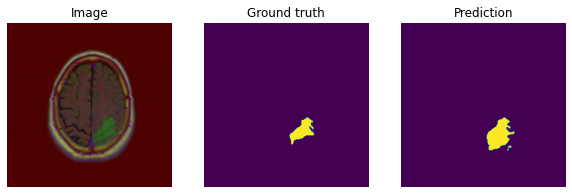

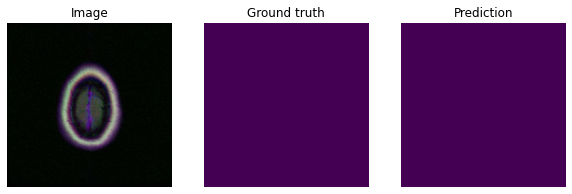

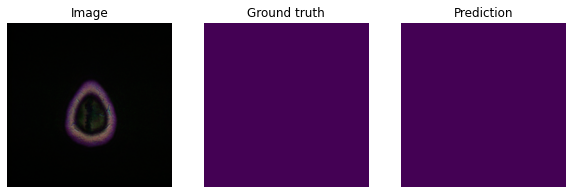

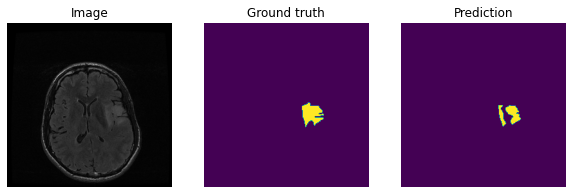

In [ ]:
# Realizamos la inferencia del modelo en un batch de datos del conjunto de pruebas
# y generamos las máscaras binarias como predicciones del modelo
batch = next(iter(test_loader))
# no se necesitan gradientes durante la inferencia
with torch.no_grad():
    # Realizamos la inferencia del modelo en los datos de entrada del batch[0].
    # El resultado es la salida logit del modelo, que representa las predicciones
    # sin procesar antes de la aplicación de la función de activación.
    model.eval()
    logits = model(batch[0])
# Aplicamos una función de activación sigmoide a las salidas logit para obtener probabilidades entre 0 y 1.
# Luego aplicamos un umbral de 0.5 para convertir las probabilidades en máscaras binarias (0 o 1)
pr_masks = (logits.sigmoid() > .5).float()


# Mostramos las imágenes de 3 pacientes
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    # Imagen estructural
    plt.subplot(1, 3, 1)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))  # cambiamos el orden CHW -> HWC
    plt.title("Image")
    plt.axis("off")
    # Imagen de la máscara real
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy()) # juntamos las clases, porque solo tenemos una clase
    plt.title("Ground truth")
    plt.axis("off")
    # Imagen de la máscara predicha
    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy()) # juntamos las clases, porque solo tenemos una clase
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

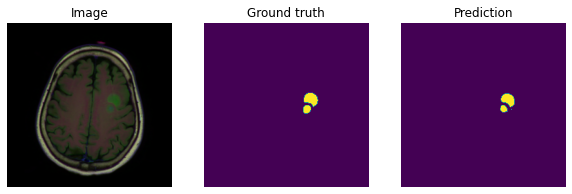

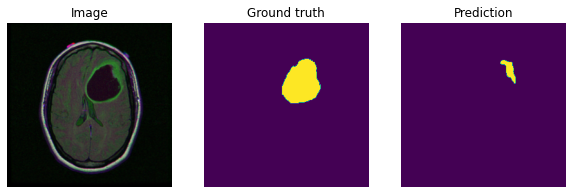

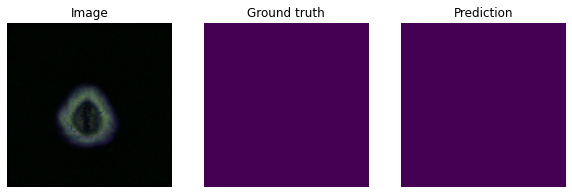

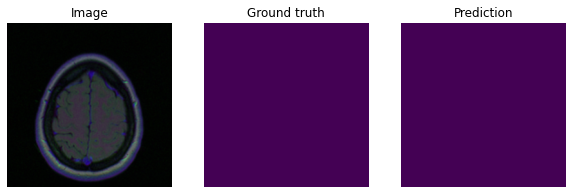

In [ ]:
# Repetimos el proceso con otro batch
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = (logits.sigmoid() > .5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

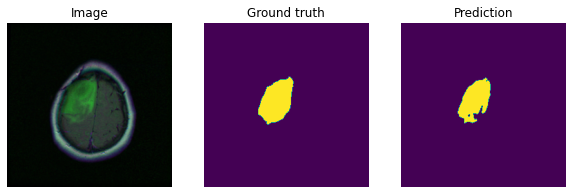

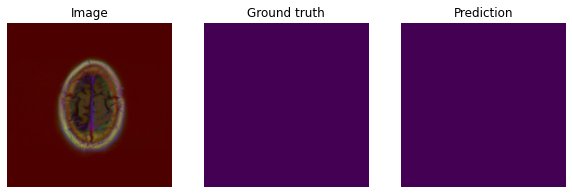

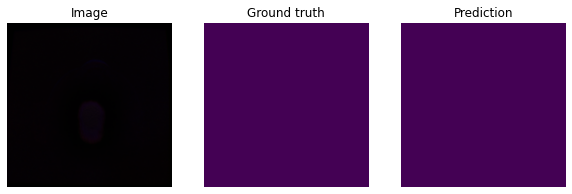

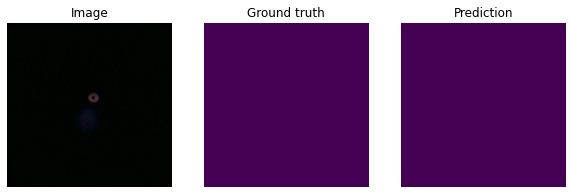

In [ ]:
# Repetimos el proceso con otro batch
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = (logits.sigmoid() > .5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

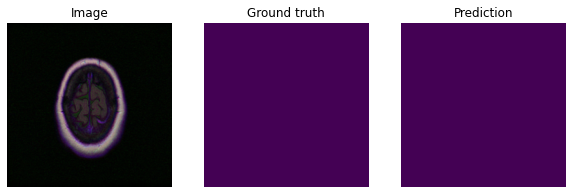

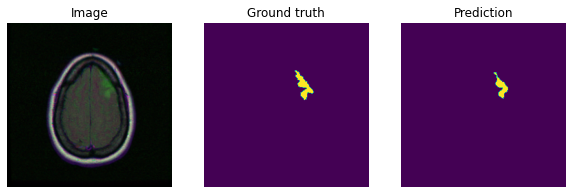

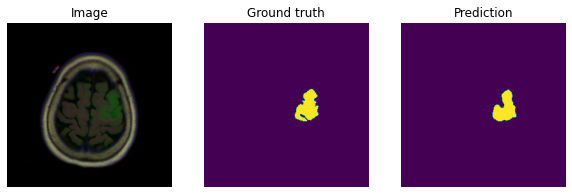

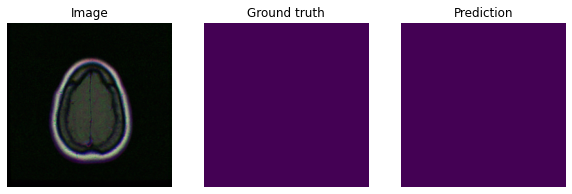

In [ ]:
# Repetimos el proceso con otro batch
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = (logits.sigmoid() > .5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.squeeze().detach().cpu().numpy())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.squeeze().numpy())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()